# 1. Setup for Training

## 1.1 Library

In [ ]:
import os
import cv2
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab import drive
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50, ResNet152V2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models, optimizers, utils, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

## 1.2 Directory Preparation

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define directories
base_dir = '/content/drive/My Drive/AAAI/DR_data_cropped_classes'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

Mounted at /content/drive


In [ ]:
# Parameter setting
batch_size = 32
img_width = img_height = 300
validation_split = 0.2
seed = 30
lr = 0.01
epochs = 40
img_size = (img_width, img_height)

In [ ]:
# For training set
train_ds = utils.image_dataset_from_directory(
    train_dir,
    validation_split = validation_split,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)

Found 4081 files belonging to 5 classes.
Using 3265 files for training.


In [ ]:
# For validation set
val_ds = utils.image_dataset_from_directory(
    train_dir,
    validation_split = validation_split,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)

Found 4081 files belonging to 5 classes.
Using 816 files for validation.


In [ ]:
# For test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)

Found 500 files belonging to 5 classes.


In [ ]:
# Show class names
class_names=train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4']


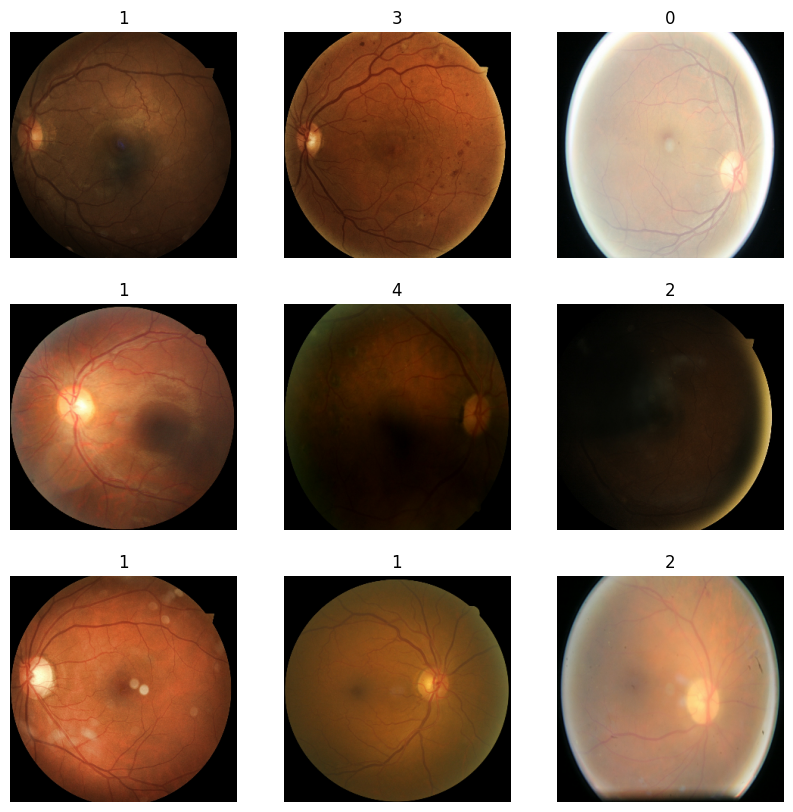

In [ ]:
# Plot sample images
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Optimizing TensorFlow data
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

This code optimizes TensorFlow data pipelines by caching, shuffling, and prefetching data to improve performance and efficiency during model training and evaluation.

## 1.3 Data Augumentation

In [ ]:
# Set data augmentation parameters
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomBrightness(0.1),
        layers.RandomContrast((0.5, 1.2)),
        layers.RandomRotation(0.1, fill_mode='constant'),
        layers.RandomZoom(height_factor=0.1, width_factor=0.1, fill_mode='constant'),
    ]
)

(-0.5, 299.5, 299.5, -0.5)

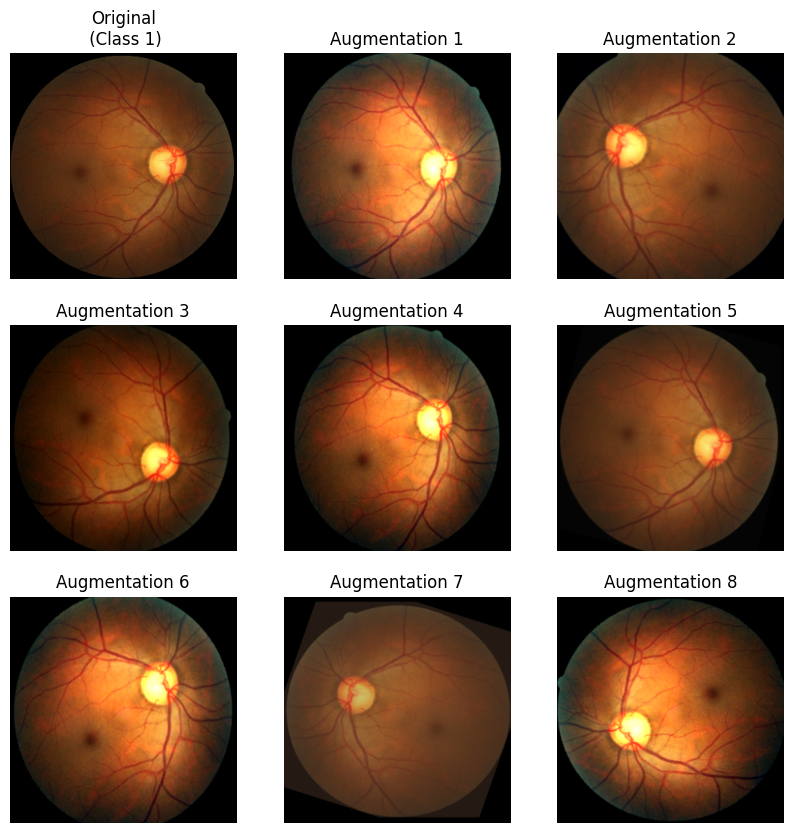

In [ ]:
# Show sample images after data aufumentation
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(f"Augmentation {i}")
        plt.axis("off")

ax = plt.subplot(3, 3, 1)
plt.imshow(first_image.numpy().astype("int32"))
plt.title(f"Original\n (Class {labels[0]})")
plt.axis("off")

#2. Training

## 2.1 Train the model

**Transfer learning**: initialize the model with pre-trained ImageNet weights, and we fine-tune it on our own dataset.

In [ ]:
# Prepare input data
input = keras.Input(shape=(*(img_size), 3))
augmented_inputs = data_augmentation(input, training=True)

# Configure base model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=augmented_inputs,
    input_shape=(*(img_size), 3)
)
base_model.trainable = False

# Add new output layers
x = base_model.output

x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)
# x = layers.BatchNormalization(name='batch_normalization')(x)
x = layers.Dropout(0.2, name='dropout1')(x)
# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dropout(0.4, name='dropout2')(x)

output = layers.Dense(5, activation='softmax', name='output')(x)
# output = layers.Dense(5, activation='softmax', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), name='output')(x)

# Create model
model = tf.keras.Model(inputs=base_model.input, outputs=output, name='TransferModelResNet')
# model.summary()

# Compile model
model.compile(optimizer=optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Configure callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-8)
callbacks = [early_stopping, reduce_lr]

# Train the model
init_time = datetime.datetime.now()

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)

required_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(required_time)}\n')

Epoch 1/40
103/103 [==============================] - 11s 72ms/step - loss: 2.3021 - accuracy: 0.3182 - val_loss: 1.8465 - val_accuracy: 0.3664 - lr: 0.0100
Epoch 2/40
103/103 [==============================] - 6s 58ms/step - loss: 1.9811 - accuracy: 0.3461 - val_loss: 1.3869 - val_accuracy: 0.4326 - lr: 0.0100
Epoch 3/40
103/103 [==============================] - 6s 58ms/step - loss: 1.9677 - accuracy: 0.3602 - val_loss: 1.5077 - val_accuracy: 0.3958 - lr: 0.0100
Epoch 4/40
103/103 [==============================] - 6s 57ms/step - loss: 1.7973 - accuracy: 0.3764 - val_loss: 1.5593 - val_accuracy: 0.4007 - lr: 0.0100
Epoch 5/40
103/103 [==============================] - 6s 58ms/step - loss: 1.4051 - accuracy: 0.4355 - val_loss: 1.2905 - val_accuracy: 0.4473 - lr: 1.0000e-03
Epoch 6/40
103/103 [==============================] - 6s 57ms/step - loss: 1.3550 - accuracy: 0.4395 - val_loss: 1.3185 - val_accuracy: 0.4338 - lr: 1.0000e-03
Epoch 7/40
103/103 [==============================] - 6

## 2.2 Save / Load the Model and History

Save

In [ ]:
models_dir = os.path.join(base_dir, 'models')
os.makedirs(models_dir, exist_ok=True)

time_stamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model.save(f'{models_dir}/cnn_{time_stamp}.keras')

hist_df = pd.DataFrame(history.history)
hist_json_file = f'{models_dir}/history_{time_stamp}.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

Load

In [ ]:
loaded_model = models.load_model(f'{models_dir}/cnn_{time_stamp}.keras')
loaded_history = pd.read_json(f'{models_dir}/history_{time_stamp}.json')

# 3. Evaluation

## 3.1. Plot Losses and Accuracies on Training and Validation Set

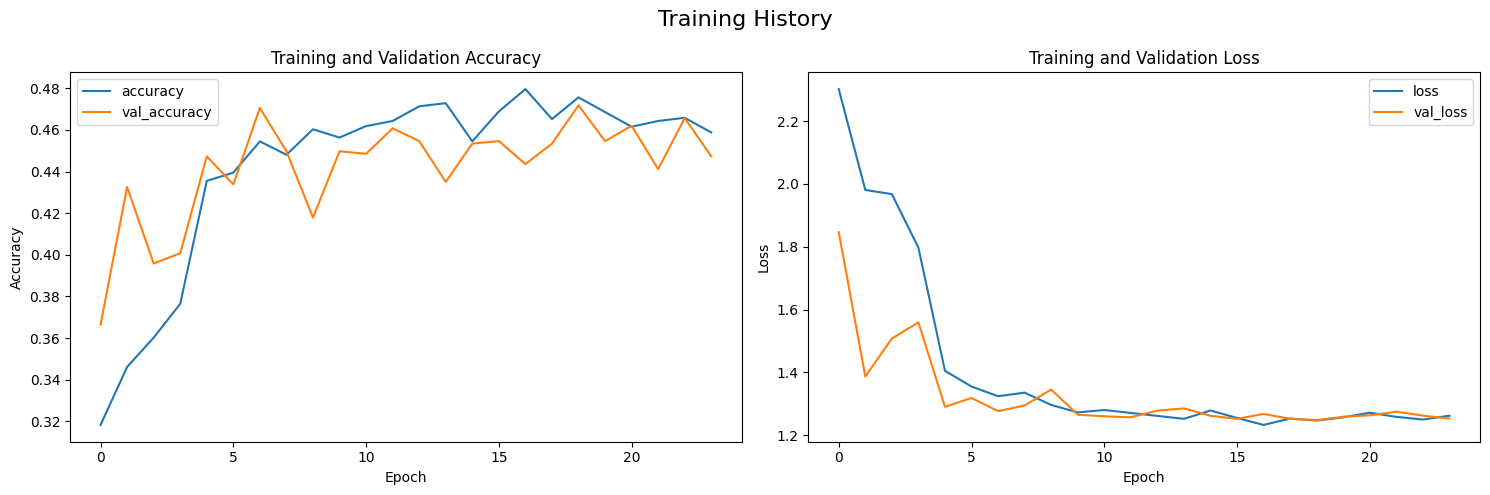

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle("Training History", fontsize=16)

loaded_history[['accuracy', 'val_accuracy']].plot(ax=axes[0])
axes[0].set_title("Training and Validation Accuracy")
axes[0].set(xlabel="Epoch", ylabel="Accuracy")

loaded_history[['loss', 'val_loss']].plot(ax=axes[1])
axes[1].set_title("Training and Validation Loss")
axes[1].set(xlabel="Epoch", ylabel="Loss")

plt.tight_layout()
plt.show()

## 3.2. Losses and Accuracies on Test Set

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss}')

16/16 [==============================] - 1s 46ms/step - loss: 1.2871 - accuracy: 0.4340
Test Accuracy: 43.40%
Test Loss: 1.2870960235595703


## 3.3 Confusion Matrix

16/16 [==============================] - 2s 44ms/step


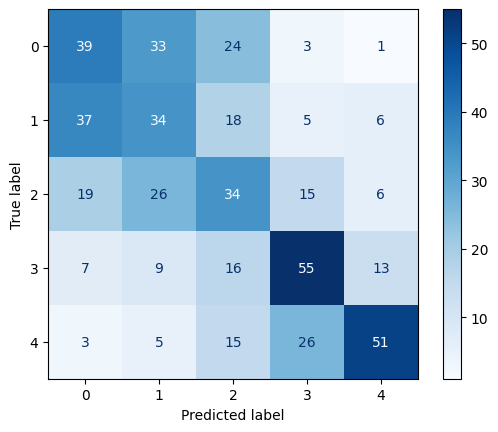

In [ ]:
# Generate predictions
predictions = model.predict(test_ds)

# Extract true labels from the test dataset
true_labels = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Identify correct and incorrect predictions
correct_predictions = np.where(predicted_labels == true_labels)[0]
incorrect_predictions = np.where(predicted_labels != true_labels)[0]

cm = confusion_matrix(true_labels, predicted_labels)
target_names = ['0', '1', '2', '3', '4']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()


## 3.4. Examples of Misclassified Images

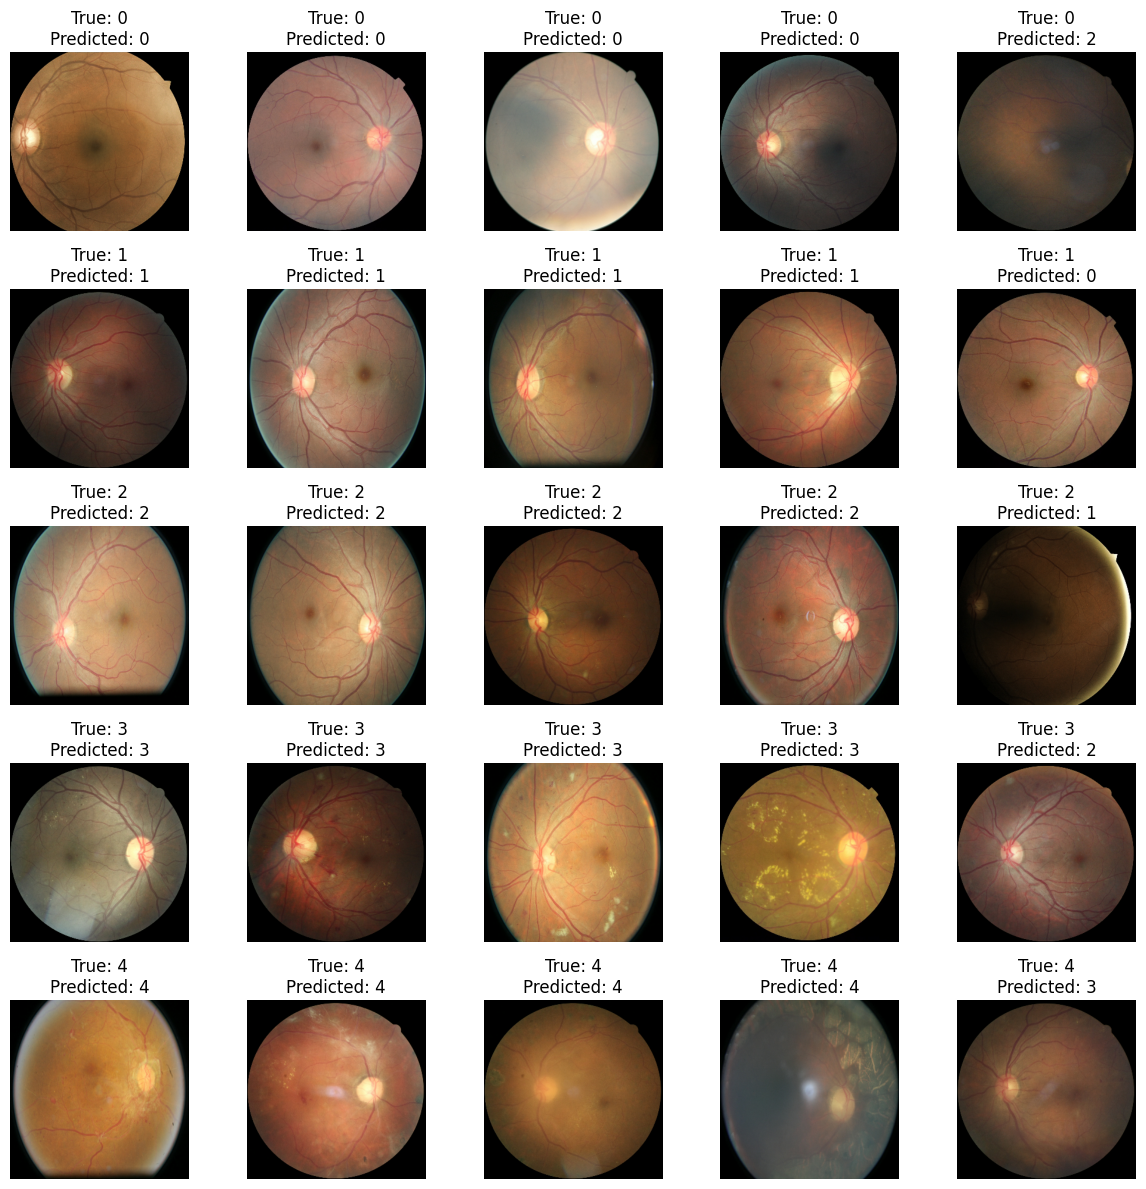

In [ ]:
def display_classwise_examples(images, true_labels, predicted_labels, title, num_classes=5):
    classes = np.unique(true_labels)

    plt.figure(figsize=(12, 12))

    for class_id in classes:
        correct_indices = np.where((true_labels == class_id) & (predicted_labels == class_id))[0]
        incorrect_indices = np.where((true_labels == class_id) & (predicted_labels != class_id))[0]

        # Display four correctly classified images
        for i in range(min(4, len(correct_indices))):
            plt.subplot(num_classes, 5, class_id * 5 + i + 1)
            plt.imshow(images[correct_indices[i]].numpy() / 255.0)
            plt.title(f'True: {class_id}\nPredicted: {predicted_labels[correct_indices[i]]}', fontsize=12)
            plt.axis('off')

        # Display one incorrectly classified image
        if len(incorrect_indices) > 0:
            plt.subplot(num_classes, 5, class_id * 5 + 5)
            plt.imshow(images[incorrect_indices[0]].numpy() / 255.0)
            plt.title(f'True: {class_id}\nPredicted: {predicted_labels[incorrect_indices[0]]}', fontsize=12)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display classwise examples
display_classwise_examples(
    [image for image, _ in test_ds.unbatch()],
    true_labels,
    predicted_labels,
    title='Class-wise Examples'
)

## 3.5. Heat map (Grad-CAM)

**Grad-CAM (Gradient-weighted Class Activation Mapping)**: It's a technique used in deep learning with convolutional neural networks (CNNs), to understand which regions of an input image are important for the network's prediction of a particular class

In [ ]:
last_conv_layer_name = "conv5_block3_out"
os.makedirs('heatmaps', exist_ok=True)

#Paths to one sample image per class
samples = [
    os.path.join(base_dir, "test/0/1012_right.jpeg"),
    os.path.join(base_dir, "test/1/1020_left.jpeg"),
    os.path.join(base_dir, "test/2/1552_left.jpeg"),
    os.path.join(base_dir, "test/3/1639_left.jpeg"),
    os.path.join(base_dir, "test/4/294_left.jpeg")
]

1/1 [==============================] - 1s 1s/step
True class: 0 - Predicted class: 2
1/1 [==============================] - 0s 31ms/step
True class: 1 - Predicted class: 1
1/1 [==============================] - 0s 28ms/step
True class: 2 - Predicted class: 4
1/1 [==============================] - 0s 29ms/step
True class: 3 - Predicted class: 3
1/1 [==============================] - 0s 29ms/step
True class: 4 - Predicted class: 4


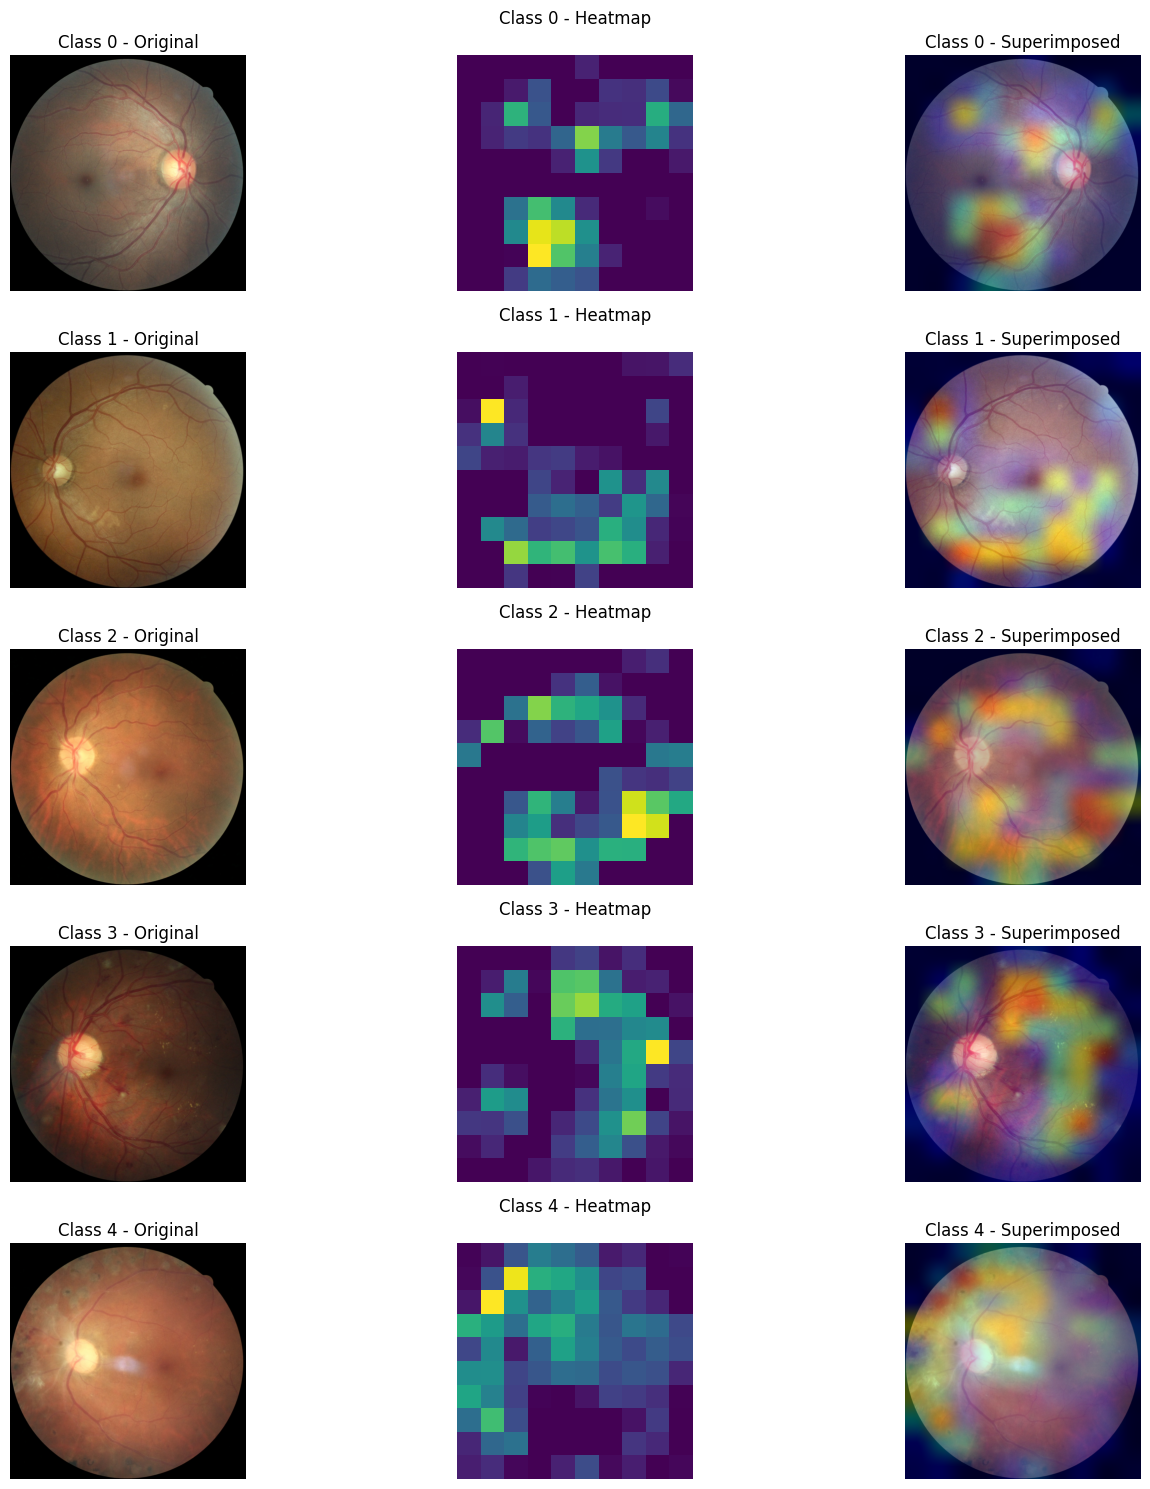

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    return superimposed_img

# Create a 2x5 grid for each sample
fig, axs = plt.subplots(5, 3, figsize=(15, 15))

for i, sample_path in enumerate(samples):

    # Prepare image
    img_array = get_img_array(sample_path, size=img_size)

    # Print the predicted class
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds[0])
    print(f"True class: {i} - Predicted class: {predicted_class}")

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Superimpose the heatmap on the image
    superimposed = save_gradcam(sample_path, heatmap, f"heatmaps/cam{i}.jpg")

    # Display the heatmap on the left and the superimposed image on the right
    axs[i, 0].imshow(load_img(sample_path))
    axs[i, 0].set_title(f"Class {i} - Original")
    axs[i, 0].axis('off')

    axs[i, 1].matshow(heatmap)
    axs[i, 1].set_title(f"Class {i} - Heatmap")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(superimposed)
    axs[i, 2].set_title(f"Class {i} - Superimposed")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()

# 4. Others

## 4.1. References

- Directory setting:
https://www.tensorflow.org/tutorials/load_data/images?hl=en

- Training:
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

    https://keras.io/api/applications/

- Data Argumentation:
https://keras.io/api/layers/preprocessing_layers/image_augmentation/

- Save model:
https://keras.io/guides/serialization_and_saving/

- Confusion Matrix:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

- Grad CAM (Attention map):
https://keras.io/examples/vision/grad_cam/

    https://www.kaggle.com/code/databeru/fish-classifier-grad-cam-viz-acc-99-89